In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from dln_dA import dA
import numpy as np
from matplotlib import pyplot as plt
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import timeit

In [3]:
# def make_simple_data(w, h, aw, ah):
#     values = np.random.uniform(0.0, 1.0, (ah, aw))
#     result = np.zeros((w, h, 3))
#     for i in range(ah):
#         for j in range(aw):
#             result[i*(h/ah):(i+1)*(h/ah), 
#                    j*(w/aw):(j+1)*(w/aw)] = values[i, j]
#     return result

# def make_simple_dataset(w, h, aw, ah, n):
#     return np.asarray([make_simple_data(w, h, aw, ah) for i in range(n)], dtype=theano.config.floatX)

import scipy.misc
def load_training_img(index):
    return scipy.misc.imread('../../TrainingData/LabeledData/capture' + str(index).zfill(6) + '.png')[:,:,:-1]

def load_images(lower, upper):
    return np.asarray([load_training_img(i) for i in range(lower, upper)])

def normalize_and_flatten(imgs):
    return (imgs / 255.0).reshape(imgs.shape[0], imgs.shape[1]*imgs.shape[2]*imgs.shape[3])

# print normalize_and_flatten(load_images(1,3))

In [4]:
tr_ex_start_index = 0
n_training_examples = 1000

training_data = normalize_and_flatten(load_images(tr_ex_start_index, tr_ex_start_index+n_training_examples))

trainig_data = np.asarray(training_data, dtype=theano.config.floatX)
train_set_x = theano.shared(training_data, name='train', borrow=True)

In [8]:
learning_rate = 10
batch_size = 10
training_epochs = 200
n_train_batches = n_training_examples/batch_size

h=64
w=64
colors=3
hidden_units=100

In [9]:
# allocate symbolic variables for the data
index = T.lscalar()    # index to a [mini]batch
x = T.matrix('x')  # the data is presented as rasterized images

rng = np.random.RandomState(123)
theano_rng = RandomStreams(rng.randint(2 ** 30))

da = dA(
    numpy_rng=rng,
    theano_rng=theano_rng,
    input=x,
    n_visible=h*w*colors,
    n_hidden=hidden_units
)

cost, updates = da.get_cost_updates(
    corruption_level=0.0,
    learning_rate=learning_rate
)

train_da = theano.function(
    [index],
    cost,
    updates=updates,
    givens={
        x: train_set_x[index * batch_size: (index + 1) * batch_size]
    }
)


In [10]:
start_time = timeit.default_timer()

############
# TRAINING #
############

# go through training epochs
for epoch in xrange(training_epochs):
    # go through trainng set
    c = []
    for batch_index in xrange(n_train_batches):
        c.append(train_da(batch_index))

    if epoch == 0 or (epoch+1) % 10 == 0:
        print 'Training epoch %d, cost ' % epoch, np.mean(c)

end_time = timeit.default_timer()

training_time = (end_time - start_time)

print 'The code ran for %.2fm' % (training_time / 60.)

Training epoch 0, cost  0.0455467033096
Training epoch 9, cost  0.0226385261207
Training epoch 19, cost  0.0206492301372
Training epoch 29, cost  0.0189302815828
Training epoch 39, cost  0.0174457055299
Training epoch 49, cost  0.0163530968253
Training epoch 59, cost  0.0155453615497
Training epoch 69, cost  0.0149077012104
Training epoch 79, cost  0.0143737975489
Training epoch 89, cost  0.0139116958362
Training epoch 99, cost  0.0135046459219
Training epoch 109, cost  0.0131419122978
Training epoch 119, cost  0.012815435164
Training epoch 129, cost  0.0125211286191
Training epoch 139, cost  0.0122538298587
Training epoch 149, cost  0.0120087390215
Training epoch 159, cost  0.0117820510566
Training epoch 169, cost  0.011571221313
Training epoch 179, cost  0.0113735202091
Training epoch 189, cost  0.0111870780632
Training epoch 199, cost  0.011010215403
The code ran for 30.59m


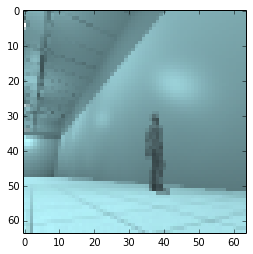

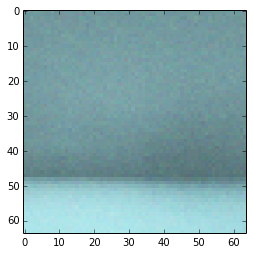

In [29]:
def make_rgb_from_val(data, w, h):
    return np.repeat(batch[index].reshape(h, w), 3).reshape(h, w, 3)

batch = training_data[10:10+batch_size]
index = 7

example_img = batch[index].reshape(h, w, colors)
plt.imshow(example_img, interpolation='nearest')
plt.show()

enc = da.get_reconstructed_input(da.get_hidden_values(da.x))

reconstr_batch = enc.eval({da.x: batch})

example_recon = reconstr_batch[index].reshape(h, w, colors)
plt.imshow(example_recon, interpolation='nearest')
plt.show()
